# Load libs

In [1]:
library(DESeq2)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



# Prepare samples

In [16]:
samples = read.csv('samples.csv',row.names = 1)
samples

,id,condition,replicate,timepoint,name
,<chr>,<chr>,<chr>,<chr>,<chr>
VL1,VL1,MLB2,s1,4d,MLB2_s1
VL2,VL2,MLB2,s2,4d,MLB2_s2
VL3,VL3,VA1,s1,4d,VA1_s1
VL4,VL4,VA1,s2,4d,VA1_s2
VL5,VL5,HAstV4,s1,4d,HAstV4_s1
VL6,VL6,HAstV4,s2,4d,HAstV4_s2
VL7,VL7,mock,s1,4d,mock_s1
VL8,VL8,mock,s2,4d,mock_s2


# Load genes

In [55]:
genes = read.table('../../ref/h38_e110_new/genes_new.gtf',sep='\t')
genes = genes[genes$V3 == 'gene',]
genes[1:3,]

,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,1,havana,gene,182696,184174,.,+,.,gene_id ENSG00000279928; gene_version 2; gene_name DDX11L17; gene_source havana; gene_biotype unprocessed_pseudogene;
8,1,havana,gene,2581560,2584533,.,+,.,gene_id ENSG00000228037; gene_version 1; gene_source havana; gene_biotype lncRNA;
13,1,ensembl_havana,gene,3069168,3438621,.,+,.,gene_id ENSG00000142611; gene_version 17; gene_name PRDM16; gene_source ensembl_havana; gene_biotype protein_coding;


In [56]:
attr_names = c('gene_id','gene_name','gene_biotype')
attrs = strsplit(genes$V9,'; ')
attrs = lapply(attrs,function(x){
    x = strsplit(x,' ')
    x = setNames(sub(';$','',sapply(x,'[',2)),
             sapply(x,'[',1))
    x[attr_names]
})
attrs = as.data.frame(do.call(rbind,attrs))
colnames(attrs) = attr_names
attrs[1:10,]

,gene_id,gene_name,gene_biotype
,<chr>,<chr>,<chr>
1,ENSG00000279928,DDX11L17,unprocessed_pseudogene
2,ENSG00000228037,NA,lncRNA
3,ENSG00000142611,PRDM16,protein_coding
4,ENSG00000284616,NA,lncRNA
5,ENSG00000157911,PEX10,protein_coding
6,ENSG00000269896,NA,transcribed_processed_pseudogene
7,ENSG00000228463,NA,transcribed_processed_pseudogene
8,ENSG00000260972,NA,lncRNA
9,ENSG00000224340,RPL21P21,processed_pseudogene


In [57]:
attrs$gene_biotype[is.na(attrs$gene_biotype)] = 'viral'

In [58]:
attrs[1:10,]

,gene_id,gene_name,gene_biotype
,<chr>,<chr>,<chr>
1,ENSG00000279928,DDX11L17,unprocessed_pseudogene
2,ENSG00000228037,NA,lncRNA
3,ENSG00000142611,PRDM16,protein_coding
4,ENSG00000284616,NA,lncRNA
5,ENSG00000157911,PEX10,protein_coding
6,ENSG00000269896,NA,transcribed_processed_pseudogene
7,ENSG00000228463,NA,transcribed_processed_pseudogene
8,ENSG00000260972,NA,lncRNA
9,ENSG00000224340,RPL21P21,processed_pseudogene


In [60]:
genes = genes[,c(1,4,5,7)]
colnames(genes) = c('chr','start','end','strand')
genes = cbind(genes,attrs)
rownames(genes) = genes$gene_id
genes[1:2,]

,chr,start,end,strand,gene_id,gene_name,gene_biotype
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000279928,1,+,ENSG00000279928,unprocessed_pseudogene,ENSG00000279928,DDX11L17,unprocessed_pseudogene
ENSG00000228037,1,+,ENSG00000228037,lncRNA,ENSG00000228037,NA,lncRNA


In [61]:
t=table(genes$gene_id)
t[t>1]

named integer(0)

In [62]:
table(genes$gene_biotype)


                          artifact                          IG_C_gene 
                                19                                 14 
                   IG_C_pseudogene                          IG_D_gene 
                                 9                                 37 
                         IG_J_gene                    IG_J_pseudogene 
                                18                                  3 
                     IG_pseudogene                          IG_V_gene 
                                 1                                145 
                   IG_V_pseudogene                             lncRNA 
                               187                              18866 
                             miRNA                           misc_RNA 
                              1879                               2221 
                           Mt_rRNA                            Mt_tRNA 
                                 2                                 22 
     

In [63]:
write.csv(genes,'../../output/brain/genes_brain.csv')

# load counts

In [64]:
counts = lapply(samples$id, function(s){
read.table(paste0('../../output/brain/counts/',s,'.tsv'),row.names = 1)
})

In [65]:
sapply(counts,function(x)all(rownames(x) == rownames(counts[[1]])))

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [66]:
counts = do.call(cbind,counts) # cbind(counts[[1]],counts[[2]],...)
colnames(counts) = samples$id
#rownames(counts)[rownames(counts)=='VA1_genome'] = 'VA1'
counts = as.matrix(counts)
counts[1:4,]

,VL1,VL2,VL3,VL4,VL5,VL6,VL7,VL8
ENSG00000000003,495,913,593,732,705,666,608,607
ENSG00000000005,4,0,0,0,0,0,0,0
ENSG00000000419,348,502,650,573,680,436,531,524
ENSG00000000457,84,137,123,92,98,70,41,69


In [67]:
mapping_qc = counts[!(rownames(counts) %in% genes$gene_id),]
counts = counts[genes$gene_id,]

In [68]:
mapping_qc = rbind(mapping_qc,t(sapply(split.data.frame(counts,genes$gene_biotype),colSums)))
mapping_qc

,VL1,VL2,VL3,VL4,VL5,VL6,VL7,VL8
__no_feature,2835019,5002841,4399253,4140854,4571791,4463479,4728009,4394718
__ambiguous,215176,404554,399020,352753,381856,326739,329597,349293
__too_low_aQual,0,0,0,0,0,0,0,0
__not_aligned,0,0,0,0,0,0,0,0
__alignment_not_unique,3394460,6020058,5737089,4934550,5421632,5093515,5647615,5400931
artifact,81,150,208,131,313,154,81,129
IG_C_gene,0,0,0,0,0,0,0,3
IG_C_pseudogene,0,0,0,0,0,0,0,0
IG_D_gene,0,0,0,0,0,0,0,0
IG_J_gene,0,0,0,0,0,0,0,0


In [69]:
stat = round(sweep(mapping_qc,2,colSums(mapping_qc),'/')*100,digits = 1)
stat[order(rowSums(stat),decreasing = T),]

,VL1,VL2,VL3,VL4,VL5,VL6,VL7,VL8
protein_coding,51.3,52.9,53.0,52.5,53.8,51.9,49.2,52.3
__alignment_not_unique,21.5,20.9,20.3,19.6,20.5,21.1,22.9,21.8
__no_feature,18.0,17.3,15.6,16.4,17.3,18.5,19.2,17.8
Mt_rRNA,3.2,3.0,3.4,3.0,3.5,3.2,3.4,3.3
lncRNA,2.4,2.3,2.3,2.3,2.3,2.7,2.5,2.4
__ambiguous,1.4,1.4,1.4,1.4,1.4,1.4,1.3,1.4
viral,1.0,0.9,3.0,3.6,0.0,0.0,0.0,0.0
Mt_tRNA,0.7,0.8,0.6,0.7,0.7,0.8,0.8,0.6
snRNA,0.2,0.2,0.1,0.2,0.2,0.2,0.2,0.2
processed_pseudogene,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [70]:
write.csv(mapping_qc,'../../output/brain/mapping_qc.csv')
write.csv(counts,'../../output/brain/counts_all_genes.csv')

# Viral expression

In [71]:
counts = as.matrix(read.csv('../../output/brain/counts_all_genes.csv',row.names = 1))
samples = read.csv('samples.csv',row.names = 1)
genes = read.csv('../../output/brain/genes_brain.csv',row.names = 1)

In [72]:
vcounts = counts[genes$gene_biotype =='viral' ,]
colnames(vcounts) = samples$name
vcounts

,MLB2_s1,MLB2_s2,VA1_s1,VA1_s2,HAstV4_s1,HAstV4_s2,mock_s1,mock_s2
HAstV4,0,0,0,0,669,911,0,0
MLB2,152981,249471,99,0,0,15,2,26
VA1,3,4,832176,894252,59,9,4,13


In [74]:
vcpm = sweep(vcounts,2,colSums(counts),'/')*1e6
#pdf('../../figures/brain/01_viral_expression.pdf',w=8,h=8.5)
par(mfrow=c(2,2),mar=c(6,4,1,0))
options(repr.plot.width = 14, repr.plot.height = 14, repr.plot.res = 150) # defaults = 7,7,120
barplot(log10(1+t(vcpm)),beside = TRUE,border=NA,xlab='Genome',ylab='log10(cpm+1)',col=colours[samples$condition])
legend('topleft',fill=colours,legend=names(colours),bty='n',border=NA)
barplot(log10(1+vcpm),beside = TRUE,border=NA,ylab='log10(cpm+1)',las=3,legend.text = TRUE,args.legend = list(bty='n',border=NA),col=colours[rownames(vcpm)])

barplot(t(vcpm),beside = TRUE,border=NA,xlab='Genome',ylab='cpm',col=colours[samples$condition])
legend('topleft',fill=colours,legend=names(colours),bty='n',border=NA)
barplot(vcpm,beside = TRUE,border=NA,ylab='cpm',las=3,legend.text = TRUE,args.legend = list(bty='n',border=NA),col=colours[rownames(vcpm)])
#dev.off()

pdf 
  2

# Human protein coding expression

In [75]:
counts = counts[genes$gene_biotype == 'protein_coding', ]
dim(counts)

[1] 20070     8

In [76]:
#write.csv(counts,'../../output/brain/counts_protein_coding.csv')

In [79]:
rownames(samples) = colnames(counts) = samples$name
deseq = DESeqDataSetFromMatrix(countData = counts,
                              colData = samples,
                               design = ~ condition)
deseq

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 20070 8 
metadata(1): version
assays(1): counts
rownames(20070): ENSG00000142611 ENSG00000157911 ... ENSG00000268674
  ENSG00000277475
rowData names(0):
colnames(8): MLB2_s1 MLB2_s2 ... mock_s1 mock_s2
colData names(7): id fname1 ... timepoint name


FALSE  TRUE 
 4965 15105 

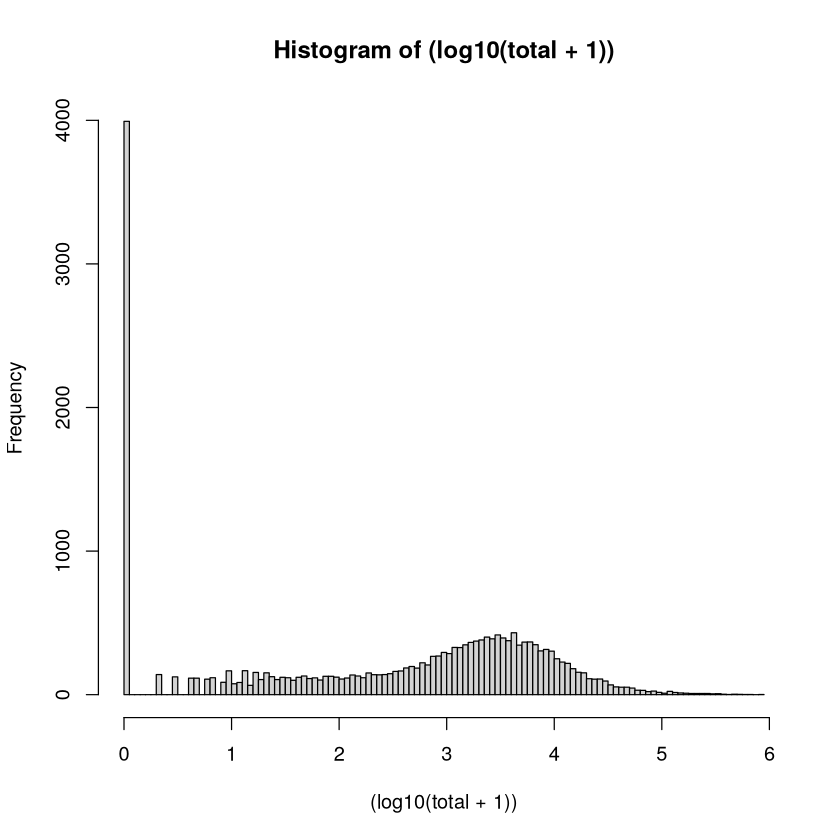

In [81]:
# filtes genes by total read counts
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 120)
total = rowSums(counts(deseq))
hist((log10(total + 1)),100)
table(total>=10)

In [82]:
counts(deseq)[1:4,]>=10

,MLB2_s1,MLB2_s2,VA1_s1,VA1_s2,HAstV4_s1,HAstV4_s2,mock_s1,mock_s2
ENSG00000142611,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
ENSG00000157911,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
ENSG00000142655,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
ENSG00000149527,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


In [83]:
# filtes genes 
nsamples10 = rowSums(counts(deseq)>=10)
table(nsamples10)

nsamples10
    0     1     2     3     4     5     6     7     8 
 5325   952   459   347   320   304   317   488 11558 

In [84]:
# remove genes with less than 10 reads in total
#deseq = deseq[total>=10,]
deseq = deseq[nsamples10>=2,]
deseq

class: DESeqDataSet 
dim: 13793 8 
metadata(1): version
assays(1): counts
rownames(13793): ENSG00000142611 ENSG00000157911 ... ENSG00000278817
  ENSG00000271254
rowData names(0):
colnames(8): MLB2_s1 MLB2_s2 ... mock_s1 mock_s2
colData names(7): id fname1 ... timepoint name

In [85]:
vsd = vst(deseq, blind=TRUE)
vsd

class: DESeqTransform 
dim: 13793 8 
metadata(1): version
assays(1): ''
rownames(13793): ENSG00000142611 ENSG00000157911 ... ENSG00000278817
  ENSG00000271254
rowData names(4): baseMean baseVar allZero dispFit
colnames(8): MLB2_s1 MLB2_s2 ... mock_s1 mock_s2
colData names(8): id fname1 ... name sizeFactor

using ntop=500 top features by variance



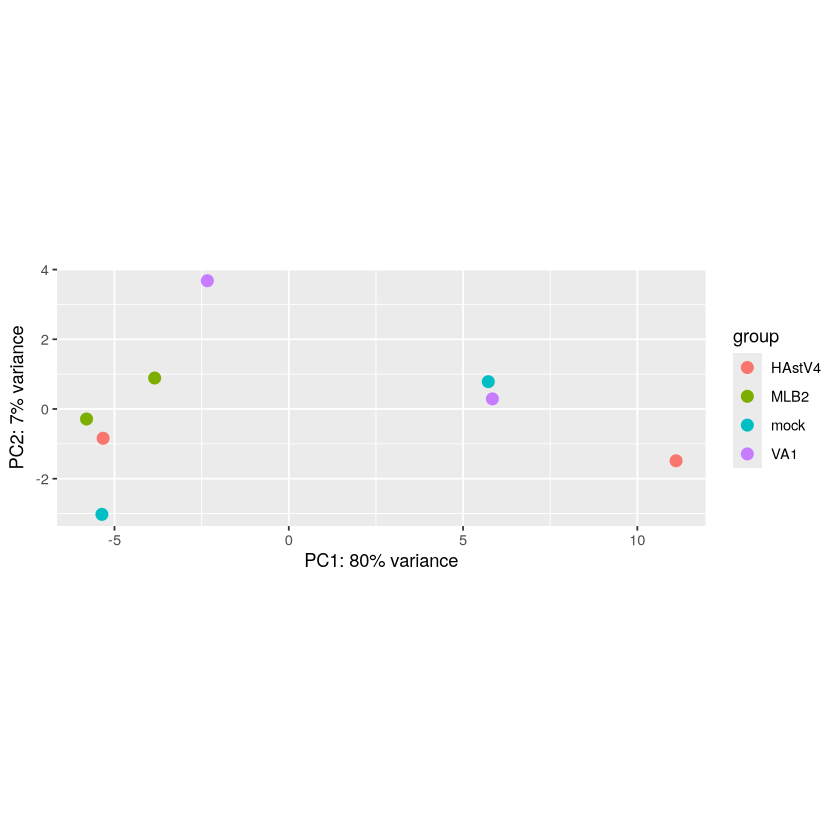

In [89]:
#pdf('../../figures/brain/02_human_plotPCA_condition.pdf',w=8,h=8.5)
plotPCA(vsd, intgroup=c("condition"))
#dev.off()

using ntop=500 top features by variance



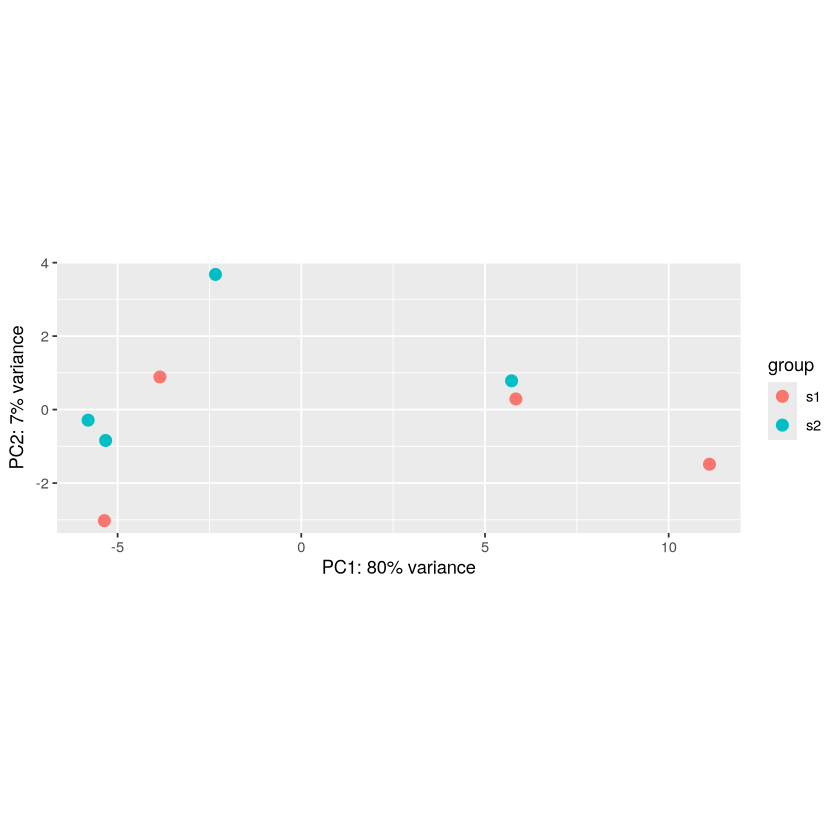

In [88]:
plotPCA(vsd, intgroup=c("replicate"))

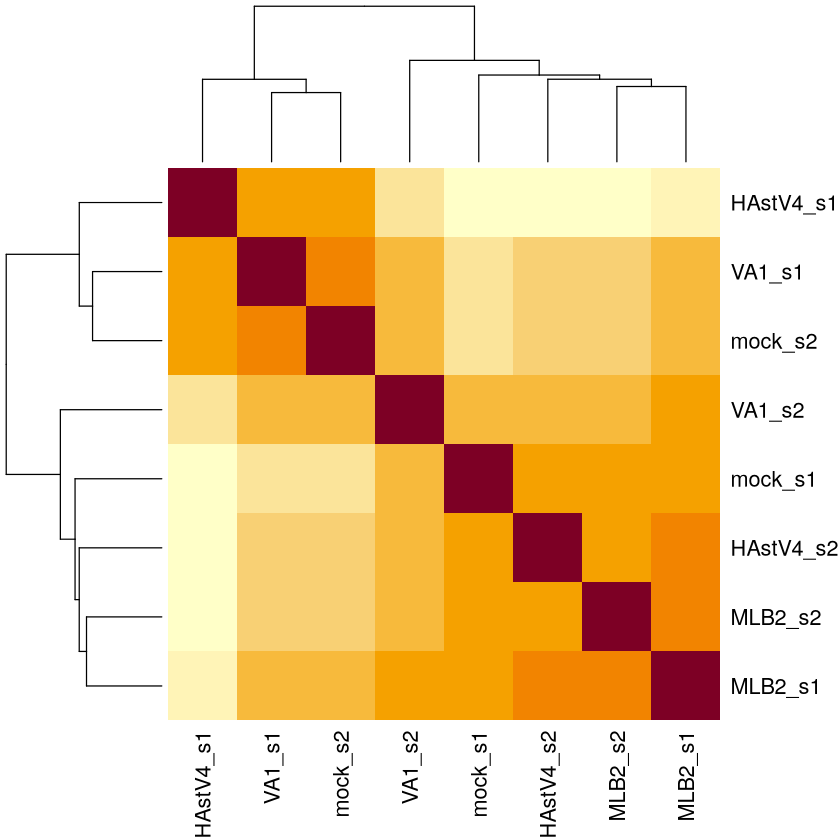

In [95]:
#pdf('../../figures/brain/03_human_heatmap.pdf',w=8,h=8.5)
cor = cor(counts(deseq),method = 'sp')
#cor = cor(vsd@assays@data[[1]],method = 'p')
heatmap(cor,distfun = function(x)as.dist(1-x),symm = TRUE,margins = c(6,6))
#dev.off()

## all viruses together

In [94]:
deseq = DESeq(deseq)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [96]:
cnds = c('MLB2','VA1','HAstV4')
res = lapply(cnds,function(c)results(deseq,contrast = c('condition','mock',c)))
names(res) = cnds

In [97]:
sapply(res,function(x){
    c(sign=sum(x$padj<0.2 & abs(x$log2FoldChange)>0))
})

MLB2.sign    VA1.sign HAstV4.sign 
          1           1           8

In [98]:
lapply(res,function(x){
    f = x$padj<0.2
    f[is.na(f)] = FALSE
    x = as.data.frame(x[f,c(1,2,6)])
    x$gene_name = genes[rownames(x),'gene_name']
    x[order(x$log2FoldChange),]
})

,baseMean,log2FoldChange,padj,gene_name
,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000120549,56.63075,-4.307891,0.05841395,KIAA1217
,baseMean,log2FoldChange,padj,gene_name
,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000117707,71.74059,-2.735477,0.151899,PROX1
,baseMean,log2FoldChange,padj,gene_name
,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000134996,22.01861,-8.2759903,0.014391531,OSTF1
ENSG00000120549,56.63075,-3.7729169,0.112426714,KIAA1217
ENSG00000117707,71.74059,-2.9096761,0.014391531,PROX1


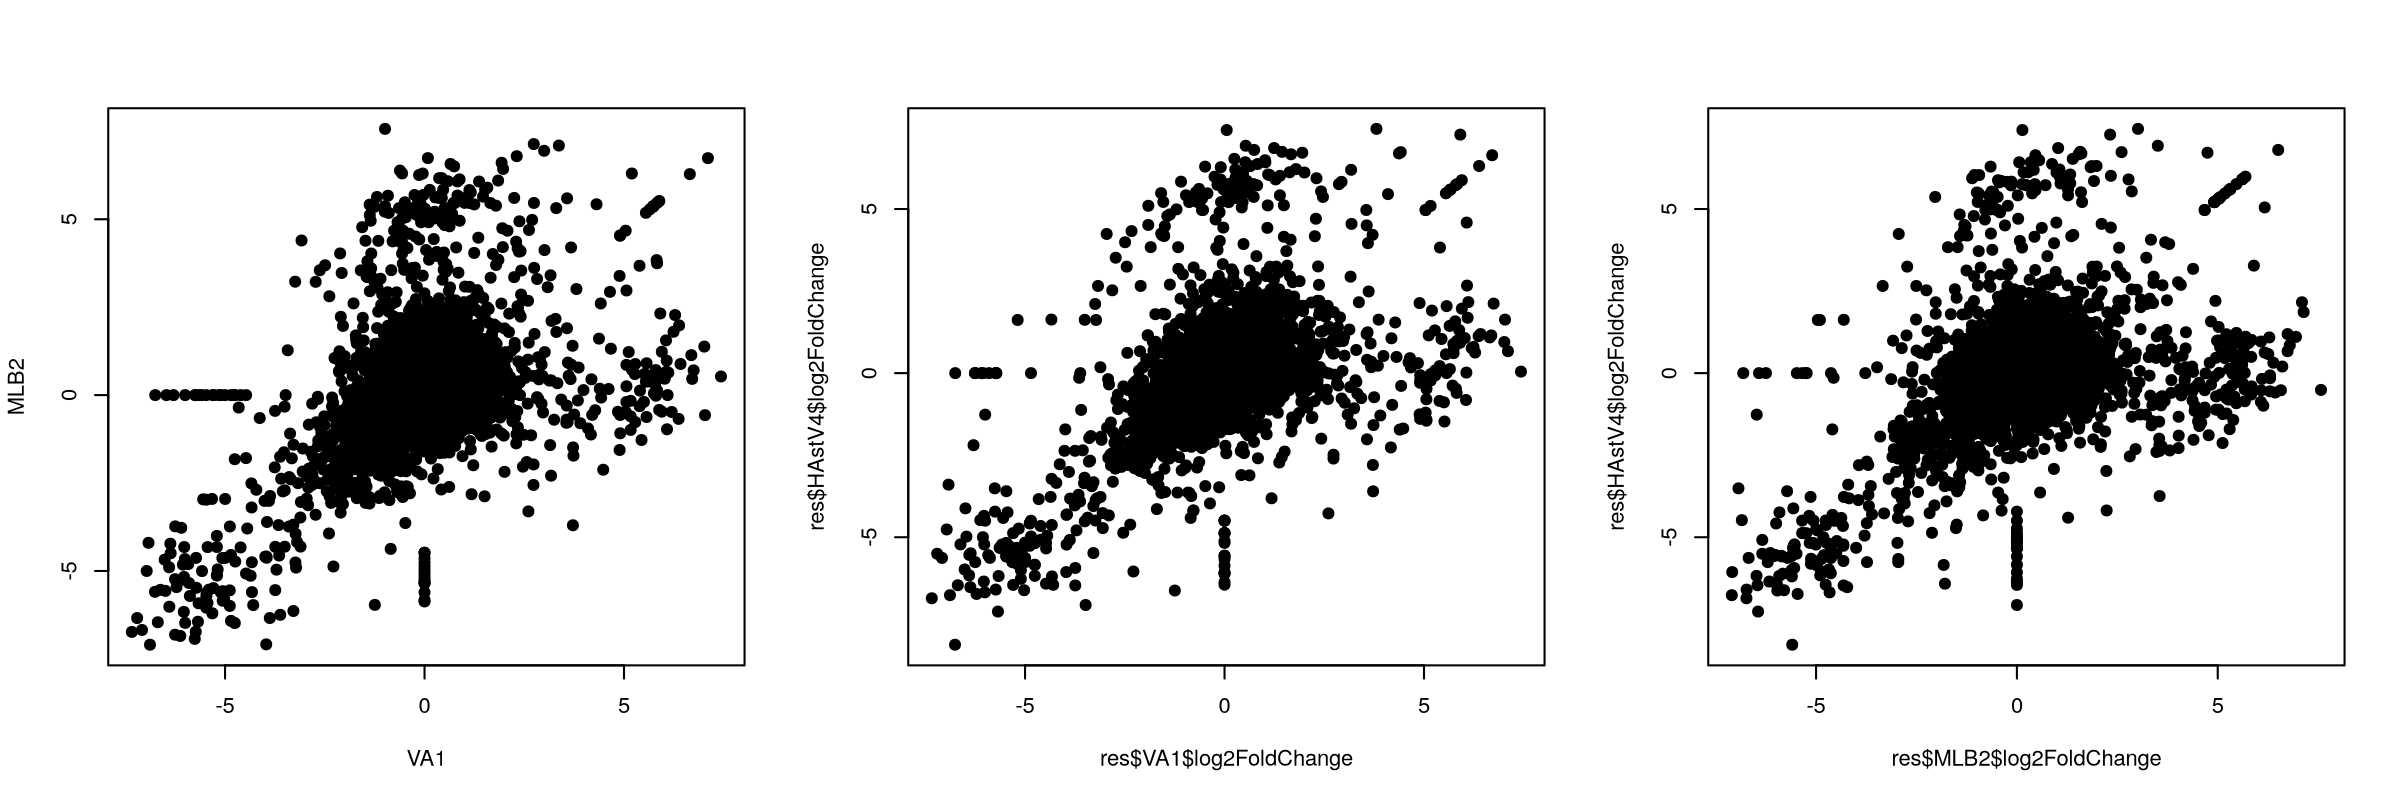

In [99]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)
par(mfrow=c(1,3))
plot(res$VA1$log2FoldChange,res$MLB2$log2FoldChange,pch=19,xlab='VA1',ylab='MLB2')
plot(res$VA1$log2FoldChange,res$HAstV4$log2FoldChange,pch=19)
plot(res$MLB2$log2FoldChange,res$HAstV4$log2FoldChange,pch=19)

In [100]:
f = res$MLB2$log2FoldChange>5 & res$VA1$log2FoldChange>5
sel = res$VA1[f,]
cbind(sel,genes[rownames(sel),'gene_name'])

DataFrame with 10 rows and 7 columns
                 baseMean log2FoldChange     lfcSE      stat     pvalue
                <numeric>      <numeric> <numeric> <numeric>  <numeric>
ENSG00000203740   3.33807        5.73612   3.55411   1.61394 0.10654091
ENSG00000173626   5.99661        6.64991   2.96425   2.24337 0.02487311
ENSG00000237541   3.18316        5.54891   4.07310   1.36233 0.17309345
ENSG00000182070   3.91979        5.64794   3.50415   1.61179 0.10700810
ENSG00000196932   3.60204        5.74123   3.53883   1.62235 0.10472828
ENSG00000183346   8.59305        5.19681   2.63420   1.97283 0.04851549
ENSG00000205693   3.48515        5.82920   3.94394   1.47801 0.13940438
ENSG00000256950   3.67160        5.88561   3.49244   1.68524 0.09194202
ENSG00000184206   4.92729        5.71745   2.80227   2.04029 0.04132134
ENSG00000124253   9.10534        7.10391   2.61028   2.72152 0.00649833
                     padj genes[rownames(sel), "gene_name"]
                <numeric>              

## One virus by one

In [101]:
cnds = c('MLB2','VA1','HAstV4')
res2 = lapply(cnds,function(c){
    f = samples$condition %in% c('mock',c)
    x = DESeqDataSetFromMatrix(countData = counts[rownames(deseq),f],
                              colData = samples[f,],
                               design = ~ condition)
    x = DESeq(x)
    results(x,contrast = c('condition','mock',c))
    })
names(res2) = cnds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [102]:
sapply(res2,function(x){
    c(sign=sum(x$padj<0.05 & abs(x$log2FoldChange)>0,na.rm=T))
})

MLB2.sign    VA1.sign HAstV4.sign 
          8           0           2

In [103]:
lapply(res2,function(x){
    f = x$padj<0.05 & abs(x$log2FoldChange)>0
    f[is.na(f)] = FALSE
    x = as.data.frame(x[f,c(1,2,6)])
    x$gene_name = genes[rownames(x),'gene_name']
    x[order(x$log2FoldChange),]
})

$MLB2
                  baseMean log2FoldChange         padj gene_name
ENSG00000120549   50.11637     -4.3102477 1.160747e-02  KIAA1217
ENSG00000113916  329.06114     -1.7771026 1.160747e-02      BCL6
ENSG00000175745 2845.22291     -1.3115234 2.433423e-10     NR2F1
ENSG00000185551  784.95780     -1.2095558 1.483149e-02     NR2F2
ENSG00000155760  743.09792     -1.1658143 1.851594e-02      FZD7
ENSG00000076356  866.29096     -0.9564076 1.483149e-02    PLXNA2
ENSG00000150471 1322.63791     -0.8491480 1.851594e-02    ADGRL3
ENSG00000174963   54.97500      4.5654600 3.421440e-02      ZIC4

$VA1
[1] baseMean       log2FoldChange padj           gene_name     
<0 rows> (or 0-length row.names)

$HAstV4
                 baseMean log2FoldChange        padj gene_name
ENSG00000134996  29.80408      -8.276793 0.031746594     OSTF1
ENSG00000168298 260.84989       1.967171 0.005380798      H1-4

In [104]:
lapply(res,function(x){
    f = x$padj<0.05 & abs(x$log2FoldChange)>1
    f[is.na(f)] = FALSE
    x = as.data.frame(x[f,c(1,2,6)])
    x$gene_name = genes[rownames(x),'gene_name']
    x[order(x$log2FoldChange),]
})

$MLB2
[1] baseMean       log2FoldChange padj           gene_name     
<0 rows> (or 0-length row.names)

$VA1
[1] baseMean       log2FoldChange padj           gene_name     
<0 rows> (or 0-length row.names)

$HAstV4
                 baseMean log2FoldChange        padj gene_name
ENSG00000134996  22.01861      -8.275990 0.014391531     OSTF1
ENSG00000117707  71.74059      -2.909676 0.014391531     PROX1
ENSG00000168298 251.87048       1.967931 0.001829131      H1-4

#res and res2 - data from "all virus together' and "one virus by one"